In [267]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Subset, Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
import random
import torchvision.transforms as transforms

plt.ion()   # interactive mode
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [128]:
""" LeNet architecture implementation
"""
from torch import nn, optim
from torch.autograd import Variable
import torch.nn.functional as F

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, (5,5), padding=2)
        self.conv2 = nn.Conv2d(6, 16, (5,5))
        self.fc1   = nn.Linear(16*5*5, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 5)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, (2,2))
#         x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


In [129]:
def weight_inits(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_normal_(m.weight)
    
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_normal_(m.weight)
    

In [130]:
def generate_prob(class_id=0, total_img=10):
    
    lines = []
    for j in range(total_img):
        row = []
        for i in range(0,5):
            if i== class_id:
                row.append(random.randrange(85, 100))
            else:
                row.append(random.randrange(0, 10))
        lines.append(row)

    lines = torch.FloatTensor(lines)
    sums = torch.sum(lines, dim=1)
    lines_prob = torch.div(lines, sums.view(-1,1))
#     print(lines_prob)
    return lines_prob
    

In [247]:
def train_model(model, criterion, optimizer, data_loader, scheduler, num_epochs=20):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train']:
            
            if phase == 'train':
                model.train()  # Set model to training mode
                
                running_loss = 0.0
                running_corrects = 0
                
                for data in data_loader:
                    inputs, labels = data
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    
                    
                    optimizer.zero_grad()
                    with torch.set_grad_enabled(True):
                        outputs = model(inputs)
                        
                        _, preds = torch.max(outputs, 1)
#                         print(preds, labels)
                        loss = criterion(outputs, labels)
                        
                        loss.backward()
                        optimizer.step()
                    
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    
                scheduler.step()
                
                epoch_loss = running_loss / train_size
                epoch_acc = running_corrects.double() / train_size

                print('{} Loss: {:.4f} Acc: {:.4f}'.format('Train', epoch_loss, epoch_acc))
                    
#             else:
                
#                 model.eval()   # Set model to evaluate mode
                
#                 running_loss = 0.0
#                 running_corrects = 0
                
#                 for data in test_loader:
#                     inputs, labels, idx = data
#                     inputs = inputs.to(device)
#                     labels = labels.to(device)
#                     optimizer.zero_grad()
#                     with torch.set_grad_enabled(False):
#                         outputs = model(inputs)
#                         _, preds = torch.max(outputs, 1)
                        
#                         loss = criterion(outputs, labels)
                
#                     running_loss += loss.item() * inputs.size(0)
#                     running_corrects += torch.sum(preds == labels.data)
                
#                 epoch_loss = running_loss / test_size
#                 epoch_acc = running_corrects.double() / test_size
                
#                 print('{} Loss: {:.4f} Acc: {:.4f}'.format('Val', epoch_loss, epoch_acc))
#                 if epoch_acc > best_acc:
#                     best_acc = epoch_acc
#                     best_model_wts = copy.deepcopy(model.state_dict())


#         print()

#     time_elapsed = time.time() - since
#     print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
#     print('Best val Acc: {:4f}'.format(best_acc))

#     # load best model weights
#     model.load_state_dict(best_model_wts)
#     return model, best_acc

In [238]:
def image_train(x, y, optimizer, model, epoch=1000):
    model.eval()
    
    for i in range(epoch):
        optimizer.zero_grad()
        logits = model(x)
        
        prob = torch.softmax(logits, -1)
        loss = y * prob.log()
        loss = - loss.sum(-1).mean()
        
        loss.backward()
        optimizer.step()
        if i % 100 == 0:
            print('loss', loss.item())
            
    print("Image training finished...")
    x = torch.tanh(x)
    return x,y
        

In [256]:
def test_model(model, criterion, optimizer, data_loader):
    model.eval()   # Set model to evaluate mode
                
    running_loss = 0.0
    running_corrects = 0

    for data in data_loader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / test_size
    epoch_acc = running_corrects.double() / test_size

    print('{} Loss: {:.4f} Acc: {:.4f}'.format('Val', epoch_loss, epoch_acc))


In [286]:
random.seed(4)
def create_dataset(t=5, img_per_class=20):
    
    images_per_class = img_per_class
    images_list = []
    labels_list = []

    for k in range(t):
        learning_rate = 0.1
        model = LeNet()
        model.apply(weight_inits)

        # generating labels
        cl1 = generate_prob(class_id=0, total_img=images_per_class)
        cl2 = generate_prob(class_id=1, total_img=images_per_class)
        cl3 = generate_prob(class_id=2, total_img=images_per_class)
        cl4 = generate_prob(class_id=3, total_img=images_per_class)
        cl5 = generate_prob(class_id=4, total_img=images_per_class)

        y = torch.cat((cl1, cl2, cl3, cl4, cl5))
        y = y[torch.randperm(y.size()[0])]
        # generating randome images
        x = torch.randn((y.size(0), 1, 28, 28), requires_grad=True)
#         print(x.size(), y.size())
        optimizer = optim.Adam([x], lr=learning_rate)

        images, labels = image_train(x, y, optimizer, model, 1000)
#         print(images.size(), labels.size())
        images_list.append(images)
        labels_list.append(labels)

    image_tensor = images_list[0].data
    label_tensor = labels_list[0]
    for i in range(1, len(images_list)):
        image_tensor = torch.cat((image_tensor, images_list[i].data))
        label_tensor = torch.cat((label_tensor, labels_list[i]), axis=0)

    print("Image size: ", image_tensor.size(), "labels size: ", label_tensor.size())
    
    dataset = torch.utils.data.TensorDataset(image_tensor, torch.max(label_tensor,1)[1])
    
    return dataset


In [287]:
train_dataset = create_dataset(t=5, img_per_class=30)

loss 1.617632269859314
loss 0.620517909526825
loss 0.618781328201294
loss 0.6182681322097778
loss 0.6180297136306763
loss 0.617892324924469
loss 0.6178056001663208
loss 0.6177469491958618
loss 0.6177054047584534
loss 0.6176744699478149
Image training finished...
loss 1.7837510108947754
loss 0.6358120441436768
loss 0.6337413787841797
loss 0.6332343816757202
loss 0.6330169439315796
loss 0.6328999996185303
loss 0.6328295469284058
loss 0.632781445980072
loss 0.6327474117279053
loss 0.6327221989631653
Image training finished...
loss 1.6976447105407715
loss 0.6294398903846741
loss 0.6251103281974792
loss 0.6241304874420166
loss 0.6237480044364929
loss 0.6235500574111938
loss 0.6234266757965088
loss 0.623345673084259
loss 0.6232882738113403
loss 0.6232452988624573
Image training finished...
loss 1.661729335784912
loss 0.6142184138298035
loss 0.6134577393531799
loss 0.6131983995437622
loss 0.6130697727203369
loss 0.6129953265190125
loss 0.6129472851753235
loss 0.6129149198532104
loss 0.6128916

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])
init_dataset = torch.utils.data.TensorDataset(image_tensor, torch.max(label_tensor,1)[1])

lengths = [int(len(init_dataset)*1.0), int(len(init_dataset)*0.0)]
train_set, test_set = torch.utils.data.dataset.random_split(init_dataset, lengths)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=0)
# test_loader = DataLoader(test_set, batch_size=64, shuffle=True, num_workers=0)

train_size = len(train_dataset)
test_size = len(test_dataset)
# net = torch.load('LeNet_5_class_pretrained_model.tar')
net = LeNet()
# net.apply(weight_inits)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(net.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

train_model(net, criterion, optimizer_ft, train_loader, exp_lr_scheduler,
                       num_epochs=50)

Epoch 0/49
----------
Train Loss: 1.0754 Acc: 0.1200
Epoch 1/49
----------
Train Loss: 1.0709 Acc: 0.1360
Epoch 2/49
----------
Train Loss: 1.0673 Acc: 0.1920
Epoch 3/49
----------
Train Loss: 1.0621 Acc: 0.1773
Epoch 4/49
----------
Train Loss: 1.0553 Acc: 0.1627
Epoch 5/49
----------
Train Loss: 1.0429 Acc: 0.2507
Epoch 6/49
----------
Train Loss: 1.0170 Acc: 0.3213
Epoch 7/49
----------
Train Loss: 0.9880 Acc: 0.3987
Epoch 8/49
----------
Train Loss: 0.9813 Acc: 0.4360
Epoch 9/49
----------
Train Loss: 0.9749 Acc: 0.4320
Epoch 10/49
----------
Train Loss: 0.9687 Acc: 0.4213
Epoch 11/49
----------
Train Loss: 0.9624 Acc: 0.4320
Epoch 12/49
----------
Train Loss: 0.9560 Acc: 0.4373
Epoch 13/49
----------
Train Loss: 0.9503 Acc: 0.4293
Epoch 14/49
----------
Train Loss: 0.9450 Acc: 0.4307
Epoch 15/49
----------
Train Loss: 0.9443 Acc: 0.4307
Epoch 16/49
----------
Train Loss: 0.9436 Acc: 0.4307
Epoch 17/49
----------
Train Loss: 0.9429 Acc: 0.4320
Epoch 18/49
----------
Train Loss: 0.9

In [279]:
test_model(net, criterion, optimizer_ft, test_loader)

Val Loss: 0.2604 Acc: 0.0400


In [226]:
torch.save(net, 'pretrained_net_on_generated_dataset.tar')

D:\Installation\anaconda\envs\dl_env\lib\site-packages\torch\serialization.py:401: UserWarning: Couldn't retrieve source code for container of type LeNet. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "


In [272]:
test_dataset = create_dataset(t=1, img_per_class=30)

loss 1.6802637577056885
loss 0.7105974555015564
loss 0.6532875299453735
loss 0.6380001902580261
loss 0.6321803331375122
loss 0.6293888688087463
loss 0.6278557777404785
loss 0.6269125938415527
loss 0.6262786984443665
loss 0.6258309483528137
Image training finished...
Image size:  torch.Size([150, 1, 28, 28]) labels size:  torch.Size([150, 5])


In [273]:
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=0)
test_size = len(test_dataset)

test_model(net, criterion, optimizer_ft, test_loader)

Val Loss: 1.6512 Acc: 0.1533


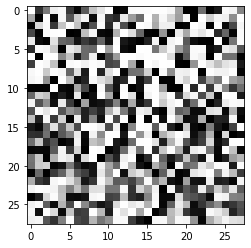

In [119]:
y = images.detach().numpy()
z = y[0,0,:,:]
plt.imshow(z, cmap='Greys', interpolation='nearest')
